# Pseudoalignment and Expectation Maximization of Transcript Counts

Aligned reads cannot neccessarily be easily assigned to transcripts. This is due to ambiguous alignment that occurrs very frequently. In practice only `30%` of reads align uniquely to a single transcript. The main reason for this is the fact that most genes have multiple transcripts that share a significant number of exons. Furthermore, genes from the same gene families share significant sequence similarity. The figure below shows an example of a gene with two transcripts and reads that align to different regions of the gene causing `ambiguous` and `unique` matches.

![Alignment ambiguity](images/alignment.jpg)

Reads in purple can come from either `transcript 1` or `transcript 2`. Some regions however are unique. This is especially true for unique splice junctions, where two exons are fused.

In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

## Naive Read Alignment Assignment

In an naive assignment we can split the count attribution between all matching transcripts. For an alignment matching transcripts `[3,4,5]` each transcript will receive a third of a read.

In [16]:
# observed alignments
aligned_reads = [[0,1], [0,3], [3,4,5], [4,5]]

counts = [0]*6

for a in aligned_reads:
    for i in a:
        counts[i] = counts[i] + 1/len(a)

print(counts)
sum(counts)

[1.0, 0.5, 0, 0.8333333333333333, 0.8333333333333333, 0.8333333333333333]


3.999999999999999

## Expectation Maximization

Instead of splitting the alignment equally, we can split the counts relative to the transcript abundance. For this we first have to define an initial state. In this example all transcripts have the same probability `counts = [1]*6`. None of the initial values should be 0 (they will stay 0 otherwise).

We will now iteratively update the probabilities (In this example `100` times), by looping over the alignments and plitting counts relative to their previous probabilities. After each iteration we replace the transcript probabilities by the newly found counts (probabilities do not need to be normalized). 

We iterate until there are only very small changes and we converged to a global maximum (it can be proven that the solution is not local but a global).

In [17]:
aligned_reads = [[0,1], [0,3], [3,4,5], [4,5]]

counts = [1]*6
temp_counts = [0]*6
intermediate_counts = []

for k in range(100):
    temp_counts = [0]*6
    for a in aligned_reads:

        sum_counts = 0
        for i in a:
            sum_counts = sum_counts + counts[i]

        for i in a:
            temp_counts[i] = temp_counts[i] + counts[i]/sum_counts
    counts = temp_counts.copy()
    intermediate_counts.append(counts)
sum(counts)

4.0

## Plotting Estimated Transcript Counts

Here we can plot the expected counts over the `100` iterations we computed. We can observe that the EM algorithm quickly converges to a solution for all transcripts.

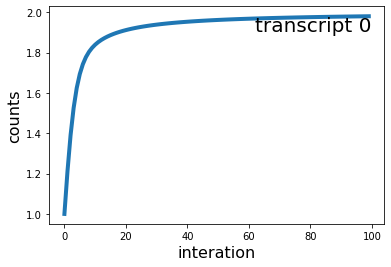

In [18]:
transcript = 0

df = pd.DataFrame(intermediate_counts)
plt.plot(df.iloc[:,transcript], linewidth=4)
plt.xlabel("interation", fontsize=16)
plt.ylabel("counts", fontsize=16)
tx = plt.text(100, np.max(df.iloc[:,transcript]), "transcript "+str(transcript), fontsize=20, verticalalignment='top', horizontalalignment='right')

## Analysis of EM Behavior

Transcript counts can look quite different with small changes in our alignment data. If we add an unambiguous alignment for transcript `3` the EM algorithm will weigh transcript 3 as much more probable.

In [19]:
aligned_reads = [[0,1], [0,3], [3,4,5], [4,5], [3]]

counts = [1]*6
temp_counts = [0]*6
intermediate_counts_2 = []

for k in range(100):
    temp_counts = [0]*6
    for a in aligned_reads:

        sum_counts = 0
        for i in a:
            sum_counts = sum_counts + counts[i]

        for i in a:
            temp_counts[i] = temp_counts[i] + counts[i]/sum_counts
    counts = temp_counts.copy()
    
    intermediate_counts_2.append(counts)

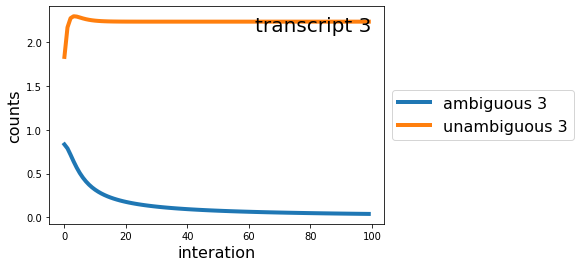

In [20]:
transcript = 3

df = pd.DataFrame(intermediate_counts)
plt.plot(df.iloc[:,transcript], linewidth=4, label="ambiguous 3")

df = pd.DataFrame(intermediate_counts_2)
plt.plot(df.iloc[:,transcript], linewidth=4, label="unambiguous 3")

plt.xlabel("interation", fontsize=16)
plt.ylabel("counts", fontsize=16)
tx = plt.text(100, np.max(df.iloc[:,transcript]), "transcript "+str(transcript), fontsize=20, verticalalignment='top', horizontalalignment='right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)

## Expectation Maximization with Transcript Length Correction

The length of transcripts matters when trying to associate reads to transcripts. Given that two genes are expressed at exactly the same level, but one transcript has a length of `2000bp` while the second has a length of only `500bp`. Assuming all things equal we would expect to find about `4` times as many reads of the longer transcript.

We can correct for such differences by multiplying the transcript length to the transcript probability. There are slightly more complicationed methods such as effective length, which take fragment length into account.

In [21]:
aligned_reads = [[0,1], [0,3], [3,4,5], [4,5]]

transcript_length = [100, 150, 400, 300, 50, 120]

counts = [1]*6
temp_counts = [0]*6
intermediate_counts_length = []

for k in range(100):
    temp_counts = [0]*6
    for a in aligned_reads:

        sum_counts = 0
        for i in a:
            sum_counts = sum_counts + counts[i]*transcript_length[i]

        for i in a:
            temp_counts[i] = temp_counts[i] + (counts[i]*transcript_length[i])/sum_counts
    counts = temp_counts.copy()
    
    intermediate_counts_length.append(counts)
sum(counts)

4.0

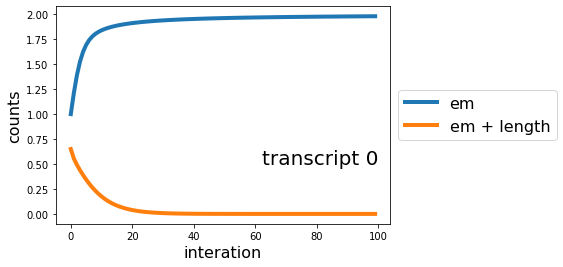

In [22]:
transcript = 0

df = pd.DataFrame(intermediate_counts)
plt.plot(df.iloc[:,transcript], linewidth=4, label="em")

df = pd.DataFrame(intermediate_counts_length)
plt.plot(df.iloc[:,transcript], linewidth=4, label="em + length")

plt.xlabel("interation", fontsize=16)
plt.ylabel("counts", fontsize=16)
tx = plt.text(100, np.max(df.iloc[:,transcript]), "transcript "+str(transcript), fontsize=20, verticalalignment='top', horizontalalignment='right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)

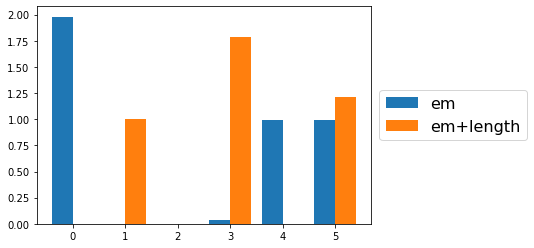

In [23]:
p = plt.bar(np.array(range(len(intermediate_counts[-1])))-0.2, intermediate_counts[-1], 0.4, label="em")
p = plt.bar(np.array(range(len(intermediate_counts_length[-1])))+0.2, intermediate_counts_length[-1], 0.4, label="em+length")
ll = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)

## More Complicated Corrections (GC Content Example)

 There are many ways the reads could be biased, with transcript length being the most straigh forward (length of transcript affects probability linearly). You can add as many corrections to the model presented before as you like and can think of. 

Medium to high GC bias seems to be more commonly found in Illumina reads (https://pubmed.ncbi.nlm.nih.gov/22323520/). Similarly to transcript length we can modify the count splitting with the corresponding bias weights.


In [24]:
aligned_reads = [[0,1], [0,3], [3,4,5], [4,5]]

transcript_length = [100, 150, 400, 300, 50, 120]

gc_content_bias = [1.2, 0.8, 1, 1.4, 1.1, 0.7]

counts = [1]*6
temp_counts = [0]*6
intermediate_counts_length_gc = []

for k in range(100):
    temp_counts = [0]*6
    for a in aligned_reads:

        sum_counts = 0
        for i in a:
            sum_counts = sum_counts + counts[i]*transcript_length[i]*gc_content_bias[i]

        for i in a:
            temp_counts[i] = temp_counts[i] + (counts[i]*transcript_length[i]*gc_content_bias[i])/sum_counts
    counts = temp_counts.copy()
    
    intermediate_counts_length_gc.append(counts)
sum(counts)

4.0

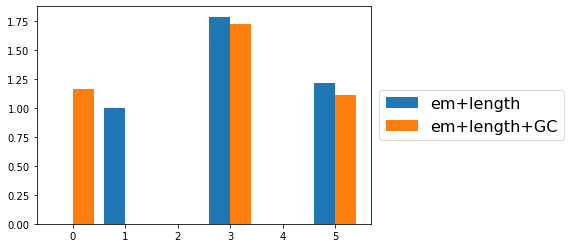

In [25]:
p = plt.bar(np.array(range(len(intermediate_counts_length[-1])))-0.2, intermediate_counts_length[-1], 0.4, label="em+length")
p = plt.bar(np.array(range(len(intermediate_counts_length_gc[-1])))+0.2, intermediate_counts_length_gc[-1], 0.4, label="em+length+GC")
ll = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)